## 0. see this article
https://medium.com/qiskit/studying-quantum-walks-on-near-term-quantum-computers-f60fd2395f04

Full paper: 
https://arxiv.org/pdf/2002.01905


## 1. Example: Implementing quantum walk on a hypercube <a name="example1"></a>
A hypercube is the $n$-dimensional counterpart of the $3$-dimensional cube. All nodes have degree $n$, and the hypercube has a total of $N=2^n$ nodes. We can represent the nodes in a hypercube graph by $n$-tuples of binary numbers. The binary representation of the neighbors of a node will differ by only one binary number. For example, in the 4-dimensional hypercube, the neighbors to $0000$ are $0001$, $0010$, $0100$, and $1000$. Thus, a node is connected to all nodes to which the Hamming distance is 1. The edges are also labeled. Two neighboring nodes that differ in the a:th bit are connected by the edge labeled $a$.

The Hilbert space representing a coined quantum walk on the hypercube is $\mathcal{H} = \mathcal{H}^n \otimes \mathcal{H}^{2^n}$, where $\mathcal{H}^n$ denotes the coin space and $\mathcal{H}^{2^n}$ the walker's position. The computational basis is

\begin{equation}
    \big\{ \ket{a,\vec{v}}, 0 \leq a \leq n-1, \vec{v} \in  \{(00...00), (00...01), ....., (11...11 )\} \big\}. N=2^n
\end{equation}

The value of the coin computational basis $a$, which is associated with edge $a$, decides where the walker should move. If the $a=0$, the walker will go to the node where the first binary value differs from the current node. If $a=1$, the walker will move to the node in which the second value differs from the current, et cetera.  Let $\vec{e}_a$ be an n-tuple where all binary values, except the value with index $a$, are $0$. Then the shift operator $S$ moves the walker from the state $\ket{a} \ket{\vec{v}}$ to $\ket{\vec{v} \oplus \vec{e}_a}$:

\begin{equation}
    S \ket{a} \ket{\vec{v}} = \ket{a} \ket{\vec{v} \oplus \vec{e}_a}.
\end{equation}

We use the Grover coin, $G$, for this walk. Thus, the evolution operator is

\begin{equation}
    U = SG.
\end{equation}

## 2. We implement a quantum walk on a N-dim hypercube.  $N=2^{nq_{Coin}}$
We need to implement the coin operator and the shift operator. We start by importing all necessary libraries from Qiskit. 

In [1032]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
#from numpy import pi
from time import time
import numpy as np
from qiskit.circuit.library import MCPhaseGate, MCXGate
from qiskit import transpile
import qiskit
from qiskit.visualization import plot_histogram
from qiskit.primitives import StatevectorSampler as Sampler
print("Qiskit version:", qiskit.__version__)

Qiskit version: 1.3.2


The circuit will have 6 qubits, 4 that represents the position and 2 that represents the coin. As we mentioned previously, the coin is a Grover coin, which is the diffuser in Grover's algorithm. We start by implementing this.

In [1033]:
# config
nqCoin=3 # cube-dimmensions
nqTheta=4 # precision of phase estimation
nqAnc=1
nqNode=1<<nqCoin
doBar=not True # inster barriers for clarity , it may skew CZ count
nqCoin,nqPos

(3, 8)

In [1034]:
# Create separate quantum registers
qrNode = QuantumRegister(nqNode, name="node")  # Position register enumerates nodes of graph
qrCoin = QuantumRegister(nqCoin, name="coin")     # Coin register 
qrTheta = QuantumRegister(nqTheta, name="theta")
qrAnc = QuantumRegister(nqAnc, name="anc")
crNode = ClassicalRegister(nqNode, 'c')
regNC= [qrNode[i] for i in range(nqNode)] + [qrCoin[i] for i in range(nqCoin)]
regTA= [qrTheta[i] for i in range(nqTheta)] + [qrAnc[0]]
regTNCA= [qrTheta[i] for i in range(nqTheta)] + [qrNode[i] for i in range(nqNode)]+ [qrCoin[i] for i in range(nqCoin)]+ [qrAnc[0]]

# Create Grover coin diffuser operator
qc = QuantumCircuit( qrNode,qrCoin, name="1 step")
if doBar: qc.barrier(qrCoin)
for qr in qrCoin:
    qc.h(qr) ; qc.z(qr)
qc.append( MCPhaseGate(np.pi, num_ctrl_qubits=nqCoin-1),qrCoin)
for qr in qrCoin:
    qc.h(qr) 
if doBar:  qc.barrier(qrCoin)   
one_step_circuit=qc # will be needed later
nCZ=transpile(qc,basis_gates=['cz','u']).count_ops().get('cz', 0)
print('Grover diffuser num CZ=',nCZ)
one_step_circuit.draw(fold=120)

Grover diffuser num CZ= 6


node_0: ──────────────────────
                              
node_1: ──────────────────────
                              
node_2: ──────────────────────
                              
node_3: ──────────────────────
                              
node_4: ──────────────────────
                              
node_5: ──────────────────────
                              
node_6: ──────────────────────
                              
node_7: ──────────────────────
        ┌───┐┌───┐       ┌───┐
coin_0: ┤ H ├┤ Z ├─■─────┤ H ├
        ├───┤├───┤ │     ├───┤
coin_1: ┤ H ├┤ Z ├─■─────┤ H ├
        ├───┤├───┤ │P(π) ├───┤
coin_2: ┤ H ├┤ Z ├─■─────┤ H ├
        └───┘└───┘       └───┘

Now, let us implement the shift operator. We know that the walker can only move to neighboring nodes, and all neighboring nodes differ by only one bit. We want to move the walker according to the coin, and we move the walker by applying a NOT gate to one of the node qubits. If the coin is in state $\ket{11}$, we move the walker to the state in which the first node qubit differ. If the coin is $\ket{10}$ or $\ket{01}$, the walker moves to the state where the second and third qubit, respectively, differ. Finally, if the Grover coin is $\ket{00}$, we flip the fourth qubit. We implement this with CCNOT- and NOT gates after the Grover coin. Together, they are one step of a quantum walk on a 4-dimensional hypercube. 

In [1035]:
# Add Shift operator function for Nd-hypercube
def shift_operator(qc):
    for i in range(nqNode):
        qc.x(qrCoin[0])
        if i%2==0:  qc.x(qrCoin[1])
        if nqCoin>2 and i%4==0:  qc.x(qrCoin[2])
        qrTmp = qrCoin[:] + [qrNode[i]]  
        qc.append(MCXGate(nqCoin), qrTmp)
    if doBar:  qc.barrier(qrCoin)       
assert nqCoin<4 # or fix above by adding more if-stetements
shift_operator(one_step_circuit) # concatenate shift to Grover diffuser

one_step_gate = one_step_circuit.to_instruction() 
print( one_step_gate)
nCZ=transpile(one_step_circuit,basis_gates=['cz','u']).count_ops().get('cz', 0)
print('one_step num CZ=',nCZ)
nRzz=transpile(one_step_gate.definition,basis_gates=['rzz','u']).count_ops().get('rzz', 0)
print('one_step_gate nRZZ=',nRzz)

one_step_circuit.draw(fold=120)
#transpile(one_step_circuit,basis_gates=['rzz','u']).draw(fold=120)

Instruction(name='1 step', num_qubits=11, num_clbits=0, params=[])
one_step num CZ= 104
one_step_gate nRZZ= 96


┌───┐                                                                      
node_0: ───────────────────────────┤ X ├──────────────────────────────────────────────────────────────────────
                                   └─┬─┘     ┌───┐                                                            
node_1: ─────────────────────────────┼───────┤ X ├────────────────────────────────────────────────────────────
                                     │       └─┬─┘     ┌───┐                                                  
node_2: ─────────────────────────────┼─────────┼───────┤ X ├──────────────────────────────────────────────────
                                     │         │       └─┬─┘     ┌───┐                                        
node_3: ─────────────────────────────┼─────────┼─────────┼───────┤ X ├────────────────────────────────────────
                                     │         │         │       └─┬─┘     ┌───┐                              
node_4: ─────────────────────────────┼─────────┼─────────┼─────────┼───────┤ X ├──────────────────────────────
                                     │         │         │         │       └─┬─┘     ┌───┐                    
node_5: ─────────────────────────────┼─────────┼─────────┼─────────┼─────────┼───────┤ X ├────────────────────
                                     │         │         │         │         │       └─┬─┘     ┌───┐          
node_6: ─────────────────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼───────┤ X ├──────────
                                     │         │         │         │         │         │       └─┬─┘     ┌───┐
node_7: ─────────────────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼───────┤ X ├
        ┌───┐┌───┐       ┌───┐┌───┐  │  ┌───┐  │  ┌───┐  │  ┌───┐  │  ┌───┐  │  ┌───┐  │  ┌───┐  │  ┌───┐└─┬─┘
coin_0: ┤ H ├┤ Z ├─■─────┤ H ├┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──
        ├───┤├───┤ │     ├───┤├───┤  │  └───┘  │  ├───┤  │  └───┘  │  ├───┤  │  └───┘  │  ├───┤  │  └───┘  │  
coin_1: ┤ H ├┤ Z ├─■─────┤ H ├┤ X ├──■─────────■──┤ X ├──■─────────■──┤ X ├──■─────────■──┤ X ├──■─────────■──
        ├───┤├───┤ │P(π) ├───┤├───┤  │         │  └───┘  │         │  ├───┤  │         │  └───┘  │         │  
coin_2: ┤ H ├┤ Z ├─■─────┤ H ├┤ X ├──■─────────■─────────■─────────■──┤ X ├──■─────────■─────────■─────────■──
        └───┘└───┘       └───┘└───┘                                   └───┘

# 4. Quantum walk search algorithm <a name="qwalkalgo"></a>
We will now implement a quantum walk search algorithm that finds a marked vertex in a graph. First, we describe the algorithm, then we go through its implementation. The quantum walk search algorithm solves the problem of finding marked vertices in a graph by a quantum walk. That is, we mark some set of vertices $|M|$, start at an arbitrary node in the graph and move according to the walk until we find the marked nodes. 

The basis states in the quantum walk search algorithm have two registers, one corresponding to the current node and the other corresponding to the previous node. That is, the basis states corresponds to the edges in the graph. We denote the quantum walk based on the classical Markov chain with transition matrix $P$ by the unitary operation $W(P)$ on $\mathcal{H}$. We also define $\ket{p_x} = \sum_y \sqrt{P_{xy}}\ket{y}$ as the uniform superposition over the node $x$'s neighbors. Let $\ket{x}\ket{y}$ be a basis state. We define the basis state $\ket{x}\ket{y}$ as ''good'' if $x$ is a marked node. Otherwise, we refer to it as ''bad''. We now introduce ''good'' and ''bad'' states: 

\begin{equation}
    \ket{G} = \frac{1}{\sqrt{|M|}} \sum_{x \in M} \ket{x} \ket{p_x}, \;
    \ket{B} = \frac{1}{\sqrt{N-|M|}} \sum_{x \notin M} \ket{x} \ket{p_x},
\end{equation}

which are the superpositions over good and bad basis states. Next, let us define $\epsilon = |M|/N$ and $\theta = \arcsin(\sqrt{\epsilon})$.


In short, the algorithm consists of three steps: 


1. Set up the initial state $\ket{U} = \frac{1}{\sqrt{N}} \sum_{x} \ket{x} \ket{p_x} = \sin{\theta} \ket{G} + \cos{\theta} \ket{B}$, a uniform superposition over all edges
2. Repeat $O(1/\sqrt{\epsilon})$ times: 
    
    (a) Reflect through $\ket{B}$
    
    (b) Reflect through $\ket{U}$

3. Do a measurement in the computational basis 


We can easily implement step $1$ with Hadamard gates and the reflection through $\ket{B}$ with a phase oracle that shifts the phase of $x$ if $x$ is in the first register, and leaves the circuit unchanged otherwise. 


Step 2(b) is equivalent to finding a unitary $R(P)$ that performs the following mapping: 
\begin{align}
    \ket{U} &\mapsto \ket{U}, \: \text{and} \\
    \ket{\psi} &\mapsto -\ket{\psi}, \: \forall \ket{\psi} \text{in the span of eigenvectors of $W(P)$ that are orthogonal to $\ket{U}$}
\end{align}

To find this operator we apply phase estimation on $W(P)$. Above we defined $W(P)$ as the evolution operator for the random walk. As we saw in section 2.A, this is a unitary operator. From this follows that the eigenvalues of $W(P)$ have norm $1$. Because of this, we can write the eigenvalues of $W(P)$ on the form $e^{\pm 2i\theta_j}$. The unitary $W(P)$ has one eigenvector with corresponding eigenvalue $1$, which is $\ket{U}$. This is given by $\theta_1=0$. $R(P)$ will find this vector $\ket{U}$ by adding a register with auxiliary qubits and perform phase estimation with precision $O(1/\sqrt{\delta})$, where $\delta$ is the spectral gap of $P$. To do this, we need to apply $W(P)$ $O(1/\sqrt{\delta})$ times. Let $\ket{w}$ be an eigenvector of $W(P)$ with eigenvalue $e^{\pm 2i\theta_j}$. Assume that $\tilde{\theta_j}$ is the best approximation to $\theta_j$ given by the phase estimation. The operation $R(P)$ that performs the mappings in for $\ket{w}$ in step 2(b) is given by [4]

\begin{equation}
    \ket{w} \ket{0} \mapsto \ket{w} \ket{\tilde{\theta_j}} \mapsto (-1)^{|\tilde{\theta_j} \neq 0|} \ket{w} \ket{\tilde{\theta_j}} \mapsto (-1)^{|\tilde{\theta_j} \neq 0|} \ket{w} \ket{0}
\end{equation}


## 5.Example: Quantum walk search on 4-dimensional hypercube<a name="qiskiti"></a>


The quantum walk search algorithm makes it possible to find a marked set of nodes in $O(1/\sqrt{\epsilon})$ steps, $\epsilon =  |M|/N$, where $M$ is the number of marked nodes and $N$ is the total number of nodes. This algorithm is originally used with Szegedy quantum walks, where we use two node registers to represent the quantum state. However, a coined walk with a Grover coin is equivalent to a Szegedy quantum walk and since implementations of coined walks are less complex in general, we choose to implement the algorithm with a coined walk. We will use the 4-dimensional hypercube that we implemented in section 3.

In short, we will implement the algorithm as follows. We achieve step 1, a uniform superposition over all edges, by applying Hadamard gates to the node qubits as well as the coin qubits. For step 2(a), we implement a phase oracle. Step 2(b) is implemented by a phase estimation on one step of the quantum walk on the hypercube followed by marking all quantum states where $\theta \neq 0$. We do this by rotating an auxiliary qubit. In the last part of this step, we reverse the phase estimation. The number of theta qubits depends on the precision of $\theta$. 

Below, we implement the quantum walk search algorithm on the 4-dimensional hypercube. 

For this algorithm we will need to use the inverse of the one step gate implemented earlier. We get this by using the built in circuit function inverse().

In [1036]:
one_step_circuit.inverse().draw(fold=130) 

┌───┐                            
node_0: ──────────────────────────────────────────────────────────────────────┤ X ├────────────────────────────
                                                                    ┌───┐     └─┬─┘                            
node_1: ────────────────────────────────────────────────────────────┤ X ├───────┼──────────────────────────────
                                                          ┌───┐     └─┬─┘       │                              
node_2: ──────────────────────────────────────────────────┤ X ├───────┼─────────┼──────────────────────────────
                                                ┌───┐     └─┬─┘       │         │                              
node_3: ────────────────────────────────────────┤ X ├───────┼─────────┼─────────┼──────────────────────────────
                                      ┌───┐     └─┬─┘       │         │         │                              
node_4: ──────────────────────────────┤ X ├───────┼─────────┼─────────┼─────────┼──────────────────────────────
                            ┌───┐     └─┬─┘       │         │         │         │                              
node_5: ────────────────────┤ X ├───────┼─────────┼─────────┼─────────┼─────────┼──────────────────────────────
                  ┌───┐     └─┬─┘       │         │         │         │         │                              
node_6: ──────────┤ X ├───────┼─────────┼─────────┼─────────┼─────────┼─────────┼──────────────────────────────
        ┌───┐     └─┬─┘       │         │         │         │         │         │                              
node_7: ┤ X ├───────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼──────────────────────────────
        └─┬─┘┌───┐  │  ┌───┐  │  ┌───┐  │  ┌───┐  │  ┌───┐  │  ┌───┐  │  ┌───┐  │  ┌───┐┌───┐        ┌───┐┌───┐
coin_0: ──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├┤ H ├─■──────┤ Z ├┤ H ├
          │  └───┘  │  ├───┤  │  └───┘  │  ├───┤  │  └───┘  │  ├───┤  │  └───┘  │  ├───┤├───┤ │      ├───┤├───┤
coin_1: ──■─────────■──┤ X ├──■─────────■──┤ X ├──■─────────■──┤ X ├──■─────────■──┤ X ├┤ H ├─■──────┤ Z ├┤ H ├
          │         │  └───┘  │         │  ├───┤  │         │  └───┘  │         │  ├───┤├───┤ │P(-π) ├───┤├───┤
coin_2: ──■─────────■─────────■─────────■──┤ X ├──■─────────■─────────■─────────■──┤ X ├┤ H ├─■──────┤ Z ├┤ H ├
                                           └───┘                                   └───┘└───┘        └───┘└───┘

The inversed one step gate will be used to reverse the phase estimation later. We need to make controlled gates from both the one step gate that we implemented in section 3 and its inverse. We will later use them depending on the value of the control qubit.

In [1037]:
# Make controlled gates
inv_cont_one_step = one_step_circuit.inverse().control()
inv_cont_one_step_gate = inv_cont_one_step.to_instruction()
cont_one_step = one_step_circuit.control()
cont_one_step_gate = cont_one_step.to_instruction()
#inv_cont_one_step.decompose().draw(fold=120)
nRzz=transpile(one_step_gate.definition,basis_gates=['rzz','u']).count_ops().get('rzz', 0)
print('one_step_gate nRZZ=',nRzz)
nRzz=transpile(cont_one_step_gate.definition,basis_gates=['rzz','u']).count_ops().get('rzz', 0)
print('cont_one_step_gate nRZZ=',nRzz)
cont_one_step.draw(fold=130)

one_step_gate nRZZ= 96
cont_one_step_gate nRZZ= 782


q5786: ─────■──────
        ┌────┴─────┐
node_0: ┤0         ├
        │          │
node_1: ┤1         ├
        │          │
node_2: ┤2         ├
        │          │
node_3: ┤3         ├
        │          │
node_4: ┤4         ├
        │          │
node_5: ┤5  1 step ├
        │          │
node_6: ┤6         ├
        │          │
node_7: ┤7         ├
        │          │
coin_0: ┤8         ├
        │          │
coin_1: ┤9         ├
        │          │
coin_2: ┤10        ├
        └──────────┘

Both the controlled one step gate and the controlled inversed one step gate will be used in the phase estimation. Another thing we will use in the phase estimation is the Quantum Fourier Transform. Qiskit has a function, QFT, which implements the Quantum Fourier Transform. The phase estimation uses the inverse Quantum Fourier Transform but we also will need to use the ordinary QFT to reverse the phase estimation.  It will act on theta angle for phaseestimation

In [1038]:
inv_qft_gate = QFT(nqTheta, inverse=True).to_instruction()  
qft_gate = QFT(nqTheta, inverse=False).to_instruction()
nRzz=transpile(qft_gate.definition,basis_gates=['rzz','u']).count_ops().get('rzz', 0)
print('QFT num Rzz=',nRzz)
inv_qft_gate.definition.draw( fold=120)
#inv_qft_gate.definition.decompose().draw( fold=120)
#qft_gate.definition.draw( fold=120)

QFT num Rzz= 6


┌──────────┐
q_0: ┤0         ├
     │          │
q_1: ┤1         ├
     │  IQFT_dg │
q_2: ┤2         ├
     │          │
q_3: ┤3         ├
     └──────────┘

Before we implement the phase estimation, we implement a phase oracle that marks Mtag=2 the states (1)011 and (1)110.

Then, we make it a circuit. This is step 2(a): Reflect through $\ket{B}$  of the algorithm.

We will now implement a gate that rotates an auxiliary qubit if the other qubits are non-zero. We will use this gate in the phase estimation, where it will rotate the auxiliary qubit if $\theta \neq 0$. 

In [1039]:
phase_circuit =  QuantumCircuit(qrNode, name='tag nodes')

#.... Mark (1)011
phase_circuit.x(2)
phase_circuit.append(  MCPhaseGate(np.pi, num_ctrl_qubits=nqNode-1), qrNode)
phase_circuit.x(2)
Mtag=1
if 1:  # add 2nd tag
    phase_circuit.barrier()
    #..... Mark (1)110
    phase_circuit.x(0)
    phase_circuit.append(  MCPhaseGate(np.pi, num_ctrl_qubits=nqNode-1), qrNode)
    phase_circuit.x(0)
    Mtag+=1

# ... estimate number of iterations
eps=Mtag/nqNode
grover_theta=np.arcsin(np.sqrt(eps))
optIter=np.pi/grover_theta-0.5
print('eps=%.2f theta=%.3f  optIter=%.1f'%(eps,grover_theta,optIter))

phase_oracle_gate = phase_circuit.to_instruction()
phase_circuit.draw()

eps=0.25 theta=0.524  optIter=5.5


░ ┌───┐       ┌───┐
node_0: ──────■───────────░─┤ X ├─■─────┤ X ├
              │           ░ └───┘ │     └───┘
node_1: ──────■───────────░───────■──────────
        ┌───┐ │     ┌───┐ ░       │          
node_2: ┤ X ├─■─────┤ X ├─░───────■──────────
        └───┘ │     └───┘ ░       │          
node_3: ──────■───────────░───────■──────────
              │           ░       │          
node_4: ──────■───────────░───────■──────────
              │           ░       │          
node_5: ──────■───────────░───────■──────────
              │           ░       │          
node_6: ──────■───────────░───────■──────────
              │P(π)       ░       │P(π)      
node_7: ──────■───────────░───────■──────────
                          ░

In [1040]:
# Mark ancilla if the other qubits are non-zero 
mark_auxiliary_circuit = QuantumCircuit(qrTheta,qrAnc, name=' mark ancilla ')
regNA=range(nqTheta+nqAnc)
mark_auxiliary_circuit.x(regNA)
mark_auxiliary_circuit.append(MCXGate(nqTheta),regNA) 
mark_auxiliary_circuit.z(qrAnc)
mark_auxiliary_circuit.append(MCXGate(nqTheta),regNA) 
mark_auxiliary_circuit.x(regNA)

mark_auxiliary_gate = mark_auxiliary_circuit.to_instruction()
mark_auxiliary_circuit.draw()

┌───┐               ┌───┐
theta_0: ┤ X ├──■─────────■──┤ X ├
         ├───┤  │         │  ├───┤
theta_1: ┤ X ├──■─────────■──┤ X ├
         ├───┤  │         │  ├───┤
theta_2: ┤ X ├──■─────────■──┤ X ├
         ├───┤  │         │  ├───┤
theta_3: ┤ X ├──■─────────■──┤ X ├
         ├───┤┌─┴─┐┌───┐┌─┴─┐├───┤
    anc: ┤ X ├┤ X ├┤ Z ├┤ X ├┤ X ├
         └───┘└───┘└───┘└───┘└───┘

Now, we will implement step 2(b)  Reflect through $\ket{U}$ of the algorithm. This step consists of a phase estimation one step of the quantum walk followed by an auxiliary qubit that we rotate if $\theta \neq 0$. For this, we use the mark_auxiliary_gate that we just created.  Thereafter, we reverse the phase estimation. 

In [1041]:
# Phase estimation
phase_estimation_circuit = QuantumCircuit(qrTheta,qrNode,qrAnc,qrCoin, name=' phase estimation ')
phase_estimation_circuit.h(qrTheta)

for i in range(nqTheta):
    stop = 2**i
    for j in range(0,stop):
        regs=[qrTheta[i]]+ regNC
        phase_estimation_circuit.append(cont_one_step,regs)

# Inverse fourier transform
phase_estimation_circuit.append(inv_qft_gate, qrTheta) 

# Mark all angles theta that are not 0 with an auxiliary qubit
phase_estimation_circuit.append(mark_auxiliary_gate, regTA)

# Reverse phase estimation
phase_estimation_circuit.append(qft_gate, qrTheta)

for i0 in range(nqTheta):
#for i in range(3,-1,-1):
    i=nqTheta-1-i0
    stop = 2**i
    for j in range(0,stop):
        regs=[qrTheta[i]]+ regNC
        phase_estimation_circuit.append(inv_cont_one_step,regs)
phase_estimation_circuit.barrier()
phase_estimation_circuit.h(qrTheta)

# Make phase estimation gate
phase_estimation_gate = phase_estimation_circuit.to_instruction()
nRzz=transpile(phase_estimation_circuit,basis_gates=['rzz','u']).count_ops().get('rzz', 0)
print('phase_estimation_circuit nRZZ=',nRzz)
phase_estimation_circuit.draw(fold=1200) 

phase_estimation_circuit nRZZ= 23520


┌───┐┌────────────┐                                                                                                                                                                                                    ┌───────┐┌─────────────────┐┌──────┐                                                                                                                                                                                                                                              ┌───────────────┐ ░ ┌───┐
theta_0: ┤ H ├┤0           ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├┤0                ├┤0     ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0              ├─░─┤ H ├
         ├───┤│            │┌────────────┐┌────────────┐                                                                                                                                                                        │       ││                 ││      │                                                                                                                                                                                                            ┌───────────────┐┌───────────────┐│               │ ░ ├───┤
theta_1: ┤ H ├┤            ├┤0           ├┤0           ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├┤1                ├┤1     ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0              ├┤0              ├┤               ├─░─┤ H ├
         ├───┤│            ││            ││            │┌────────────┐┌────────────┐┌────────────┐┌────────────┐                                                                                                                │  IQFT ││                 ││  QFT │                                                                                                                                        ┌───────────────┐┌───────────────┐┌───────────────┐┌───────────────┐│               ││               ││               │ ░ ├───┤
theta_2: ┤ H ├┤            ├┤            ├┤            ├┤0           ├┤0           ├┤0           ├┤0           ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤2      ├┤2                ├┤2     ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0              ├┤0              ├┤0              ├┤0              ├┤               ├┤               ├┤               ├─░─┤ H ├
         ├───┤│            ││            ││            ││            ││            ││            ││            │┌────────────┐┌────────────┐┌────────────┐┌────────────┐┌────────────┐┌────────────┐┌────────────┐┌────────────┐│       ││                 ││      │┌───────────────┐┌───────────────┐┌───────────────┐┌───────────────┐┌───────────────┐┌───────────────┐┌───────────────┐┌───────────────┐│               ││               ││               ││               ││               ││               ││               │ ░ ├───┤
theta_3: ┤ H ├┤            ├┤            ├┤            ├┤            ├┤            ├┤            ├┤            ├┤0           ├┤0           ├┤0           ├┤0           ├┤0           ├┤0           ├┤0           ├┤0           ├┤3      ├┤3                ├┤3     ├┤0              ├┤0              ├┤0              ├┤0              ├┤0           

Now we implement the whole quantum walk search algorithm using the gates we made previously. We start by applying Hadamard gates to node and coin qubits, which is step 1 in the algorithm. Thereafter, we iteratively apply the phase oracle gate and the phase estimation gate (steps 2(a) and 2(b)). We need $O(1/\sqrt{\epsilon})$ iterations as stated in the description of the algorithm in section 4. Lastly, we measure the node qubits. 

In [1042]:
# Implementation of the full quantum walk search algorithm
circuit =QuantumCircuit(qrTheta,qrNode,qrCoin, qrAnc,crNode,name='QW full')

# Apply Hadamard gates to the qubits that represent the nodes and the coin
circuit.h( regNC) 
iterations = int(optIter)-1

for i in range(iterations):
    circuit.append(phase_oracle_gate, qrNode) 
    circuit.append(phase_estimation_gate, regTNCA) 

circuit.measure(qrNode,crNode)
T0=time()
nRzz=transpile(circuit,basis_gates=['rzz','u']).count_ops().get('rzz', 0)
elaT=time()-T0
print('circuit nRZZ=%d transp elaT=%.1f'%(nRzz,elaT))
#circuit.draw(fold=128)

circuit nRZZ=95736 transp elaT=9.7


Finally we run the implementation on the qasm simulator. We see that the circuit collapse to the marked states a clear majority of the times

In [1043]:
def ibmsim(circ):
  ibmqBE = Sampler()
  shots= nqNode*10_000
  return ibmqBE.run([circ], shots=shots).result()[0].data.c.get_counts()

T0=time()
result = ibmsim(circuit)
elaT=time()-T0
print('simu nq=%d numIter=%d elaT=%.1f'%(circuit.num_qubits,iterations,elaT))

simu nq=16 numIter=4 elaT=11.5


{'11111011': 716, '11111110': 697, '01011011': 380, '01011110': 359, '11101001': 354, '01111111': 354, '11000110': 350, '00010011': 348, '01011100': 348, '11010001': 347}


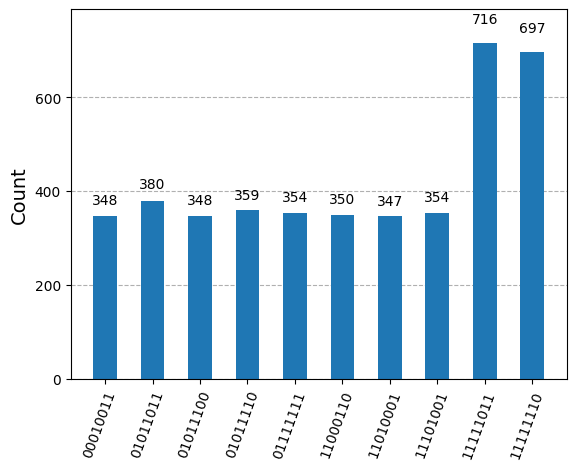

In [1044]:
top_10 = dict(sorted(result.items(), key=lambda item: item[1], reverse=True)[:10])
print(top_10)
plot_histogram(top_10)

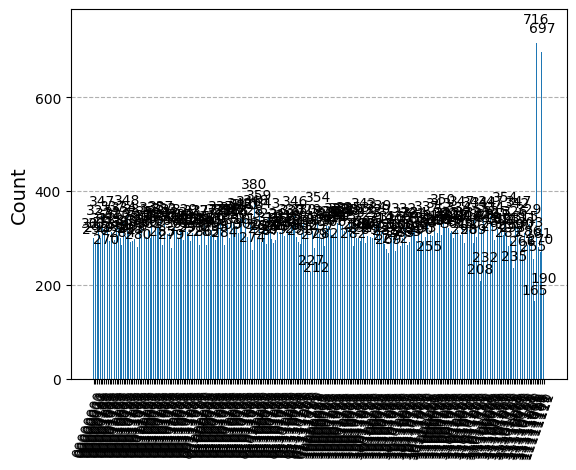

In [1045]:
plot_histogram(result)

## 6. References <a id='references'></a>

1. Renato Portugal. Quantum Walks and Search Algorithms. New York, NY: Springer New York, 2013
2. Markus G. Kuhn.Some Introductory Notes on Quantum Computing. Apr. 2000
3. Thomas G. Wong. “Equivalence of Szegedy’s and coined quantum walks”. In: Quantum InformationProcessing 16.9 (July 2017). ISSN: 1573-1332. DOI:10.1007/s11128-017-1667-y. URL:http://dx.doi.org/10.1007/s11128-017-1667-y.37
4. Ronald de Wolf. Quantum Computing: Lecture Notes. 2021. arXiv:1907.09415 [quant-ph]